This is a brief tutorial regarding the use of Random Forest to develop new scoring function.
Needs to install Anaconda (https://www.continuum.io/downloads , python version 3.6)

#install package

conda install numpy matplotlib

conda install scipy scikit-learn seaborn

conda install -c conda-forge xgboost=0.6a2

conda install -c conda-forge pydotplus

#open the notebook in yourfolder

jupyter notebook


# Staring Tutorial

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

color = sns.color_palette()

In [2]:
# for models

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, train_test_split, KFold
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble.partial_dependence import plot_partial_dependence
from sklearn.ensemble.partial_dependence import partial_dependence

from scipy.stats.stats import pearsonr

In [3]:
from IPython.display import Image
import pydotplus

In [4]:
# read in data 
traindf = pd.read_csv('data/PDBbind_vina6_train.csv')
testdf = pd.read_csv('data/PDBbind_vina6_test.csv')

In [5]:
traindf.head(3)

,pdb,gauss1,gauss2,repulsion,hydrophobic,hbond,nrot,vina,pkd
0,184l,-33.662306,-528.930696,-0.405366,-53.658468,0.0,2.0,4.893687,4.72
1,185l,-34.230024,-504.172620,-0.712744,-37.732352,0.0,0.0,4.538638,3.54
2,186l,-35.048164,-558.849670,-0.927438,-54.292838,0.0,3.0,4.469118,4.85


In [6]:
traindf.describe()

,gauss1,gauss2,repulsion,hydrophobic,hbond,nrot,vina,pkd
count,3336.000000,3336.000000,3336.000000,3336.000000,3336.000000,3336.000000,3336.000000,3336.000000
mean,-67.468406,-969.036064,-3.441709,-22.470986,-3.799166,7.404227,5.165168,6.225225
std,26.703803,410.251945,1.917357,20.377186,2.562255,5.702406,1.764170,2.139956
min,-218.597332,-3082.383593,-15.844859,-131.225250,-15.993253,0.000000,-4.335666,-0.150000
25%,-85.800302,-1217.174708,-4.517567,-35.601269,-5.395351,3.500000,3.922683,4.687500
50%,-64.198905,-907.944196,-3.119924,-18.252762,-3.450290,6.000000,5.124965,6.345000
75%,-47.021020,-664.470041,-2.037401,-4.633696,-1.815735,9.500000,6.349995,7.740000
max,-5.069520,-96.617791,-0.055892,0.000000,0.000000,42.500000,11.293774,13.000000


In [7]:
testdf.describe()

,gauss1,gauss2,repulsion,hydrophobic,hbond,nrot,vina,pkd
count,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000
mean,-67.708773,-964.859079,-3.469273,-24.720016,-3.858483,6.720513,5.449859,6.295897
std,24.139514,354.752395,1.828057,19.946025,2.732448,5.263186,1.728477,2.250904
min,-156.773527,-2102.125535,-10.619956,-102.775730,-15.529963,0.000000,0.502679,2.070000
25%,-82.643054,-1226.614619,-4.461743,-37.540748,-5.747944,3.500000,4.184173,4.600000
50%,-64.572027,-923.139733,-3.260678,-20.784822,-3.454474,5.000000,5.273505,6.270000
75%,-49.590396,-664.408352,-2.150625,-8.959760,-1.714328,8.250000,6.597305,7.980000
max,-22.711801,-420.035793,-0.162300,0.000000,0.000000,34.000000,11.819345,11.520000


In [8]:
testdf.head()

,pdb,gauss1,gauss2,repulsion,hydrophobic,hbond,nrot,vina,pkd
0,10gs,-82.076308,-1008.198967,-3.857677,-25.970168,-5.160107,13.5,4.929232,6.40
1,1a30,-62.847097,-958.542740,-3.455567,-15.031663,-2.636701,12.5,3.666491,4.30
2,1bcu,-45.249317,-635.009529,-0.466092,-8.180374,-0.548346,0.5,4.955308,3.28
3,1e66,-92.762719,-986.928373,-1.611327,-65.450145,0.000000,1.5,8.577114,9.89
4,1f8b,-53.149217,-782.381801,-4.072825,-6.739578,-4.855794,7.0,3.967290,5.40


# Pairwise relationship between features and pKd

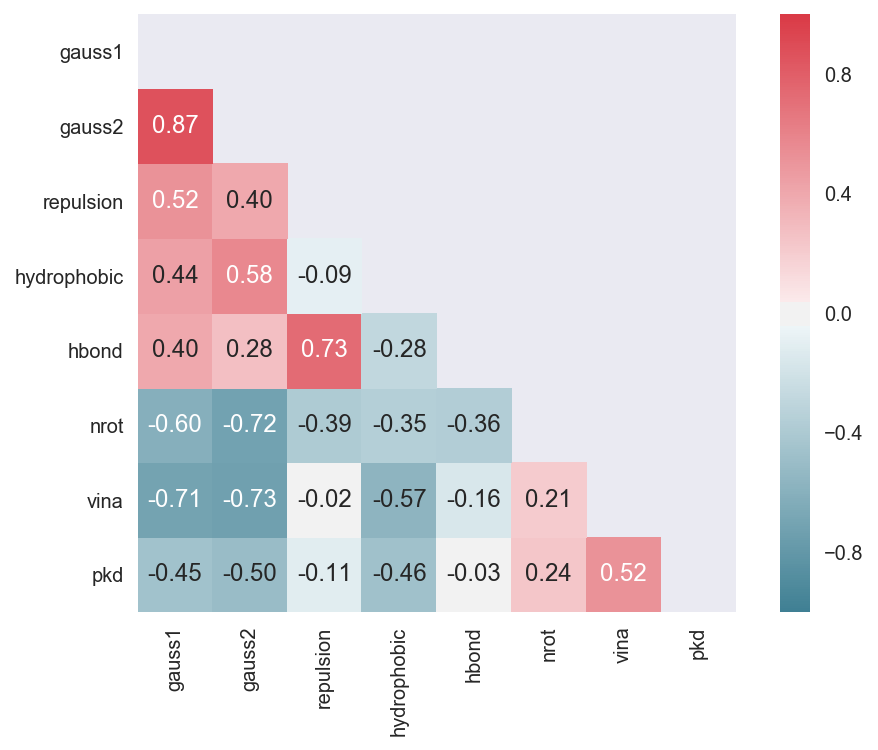

In [9]:
sns.set_style("dark")

def plot_corr(predictors):
    predictors = predictors[:]
    mcorr = traindf[predictors].corr()
    mask = np.zeros_like(mcorr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    g = sns.heatmap(mcorr, mask=mask, cmap=cmap, square=True, annot=True, fmt='0.2f')
    g.set_xticklabels(predictors, rotation=90)
    g.set_yticklabels(reversed(predictors))
    plt.show()
    
plot_corr(['gauss1','gauss2','repulsion','hydrophobic','hbond','nrot','vina','pkd'])

In [10]:
feats = ['gauss1','gauss2','repulsion','hydrophobic','hbond','nrot']

In [11]:
trainX = traindf[['gauss1','gauss2','repulsion','hydrophobic','hbond','nrot']]
trainY = traindf[['pkd']]
testX = testdf[['gauss1','gauss2','repulsion','hydrophobic','hbond','nrot']]
testY = testdf[['pkd']]

In [12]:
def getRSD(trainPredY, trainY, testPredY, testY):
    """
    Calculate the R and SD between predicated values and experimental values
    """
    
    lm = LinearRegression()
    lm.fit(trainPredY, trainY)
    trainR = lm.score(trainPredY, trainY)**0.5
    trainSD = np.sqrt(np.average((lm.predict(trainPredY) - trainY)**2))
    
    lm = LinearRegression()
    lm.fit(testPredY, testY)
    testR = lm.score(testPredY, testY)**0.5
    testSD = np.sqrt(np.average((lm.predict(testPredY) - testY)**2))
    print("Train R: %.3f, SD: %.2f; Test  R: %.3f, SD: %.2f"%(trainR, trainSD, testR, testSD))
    
    return trainR, trainSD, testR, testSD

In [13]:
def plotpKd(trainPredY, trainY, testPredY, testY):
    sns.set_context("notebook", font_scale=1.2)
    sns.set_style("ticks")

    rsd = getRSD(trainPredY, trainY, testPredY, testY)
    plt.figure(figsize = (8,4))
    
    plt.subplot(121)
    sns.regplot(x = trainY, y = trainPredY.ravel(), color = 'k', scatter_kws = {'s':3, 'lw':2, 'color':color[0]})
    sns.despine()
    plt.xlabel(r'Experimental pK$_{\mathrm{d}}$')
    plt.ylabel(r'Predict pK$_{\mathrm{d}}$')
    plt.xlim(0,14)
    plt.ylim(0,14)
    plt.title('Train Set (R: %.3f, SD: %.2f)' %(rsd[0],rsd[1]))

    plt.subplot(122)
    sns.regplot(x = testY, y = testPredY.ravel(),color = 'k', scatter_kws = {'s':3, 'lw':2, 'color':color[0]})
    sns.despine()
    plt.xlabel(r'Experimental pK$_{\mathrm{d}}$')
    plt.ylabel(r'Predict pK$_{\mathrm{d}}$')
    plt.xlim(0,14)
    plt.ylim(0,14)
    plt.title('Test Set (R: %.3f, SD: %.2f)' %(rsd[2],rsd[3]))
    plt.tight_layout()

    plt.show()

Train R: 0.520, SD: 1.83; Test  R: 0.567, SD: 1.85


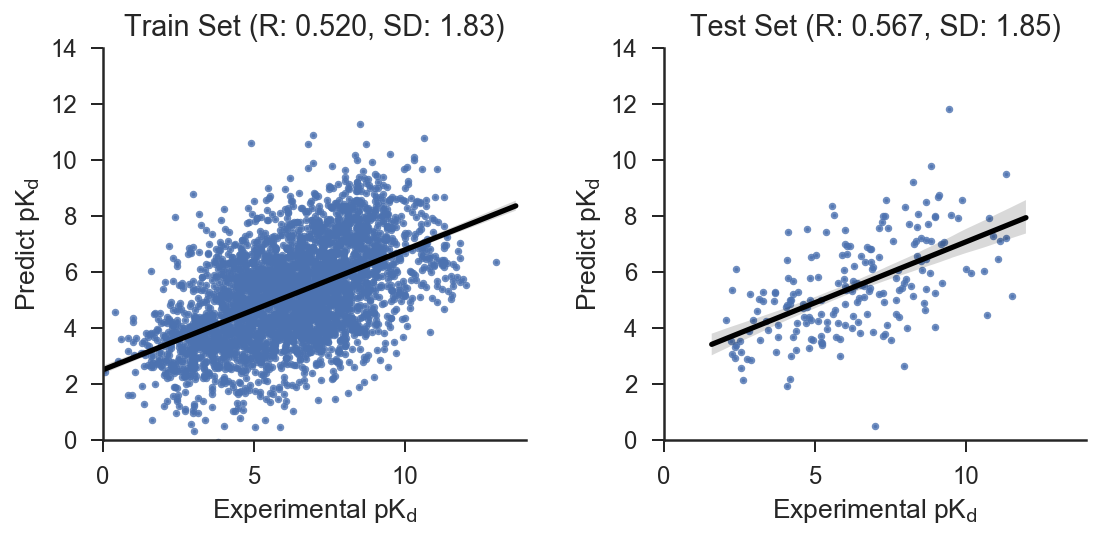

In [14]:
plotpKd(traindf[['vina']].values, trainY, testdf[['vina']].values, testY)

# Linear Regression

In [15]:
rsd = getRSD(traindf[['vina']], trainY, testdf[['vina']], testY)

Train R: 0.520, SD: 1.83; Test  R: 0.567, SD: 1.85


In [16]:
# normalize the features for linear regression
scaler = StandardScaler()
scaler = scaler.fit(trainX)

trainXscale = scaler.transform(trainX)
testXscale = scaler.transform(testX)

In [17]:
# Create linear regression object
lm = LinearRegression()
# Train the model using the training sets
lm.fit(trainXscale, trainY)
# predict on training set
trainPredY = lm.predict(trainXscale)
# predict on test set
testPredY = lm.predict(testXscale)
# get the R and SD
rsd = getRSD(trainPredY, trainY, testPredY, testY)

Train R: 0.573, SD: 1.75; Test  R: 0.627, SD: 1.75


Train R: 0.573, SD: 1.75; Test  R: 0.627, SD: 1.75


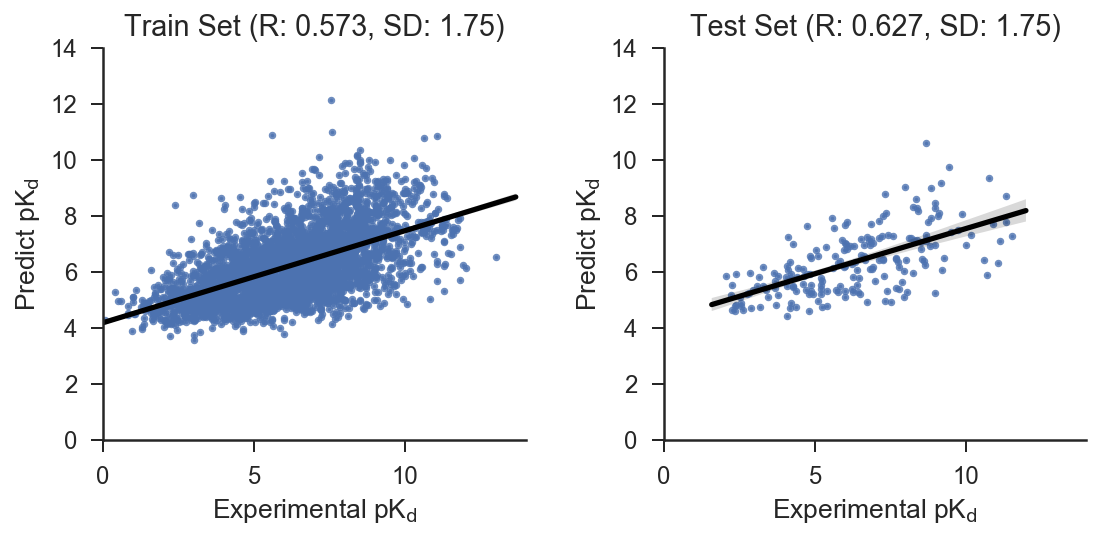

In [18]:
plotpKd(trainPredY, trainY, testPredY, testY)

# Tree Regression

In [19]:
tr = DecisionTreeRegressor( max_depth =20, min_samples_split =10)
tr.fit(trainX, trainY)
trainPredYtr = tr.predict(trainX)
testPredYtr = tr.predict(testX)

rsd = getRSD(trainPredYtr.reshape(-1,1), trainY, testPredYtr.reshape(-1,1), testY)

Train R: 0.920, SD: 0.84; Test  R: 0.447, SD: 2.01


Train R: 0.920, SD: 0.84; Test  R: 0.447, SD: 2.01


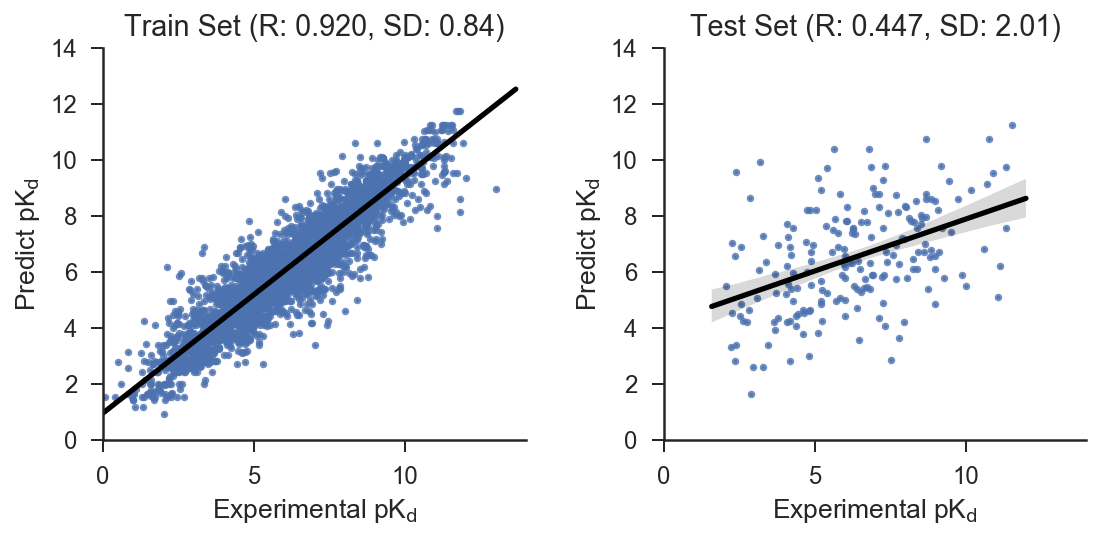

In [20]:
plotpKd(trainPredYtr.reshape(-1,1), trainY, testPredYtr.reshape(-1,1), testY)

We can see that the above tree regression is significantly overfitted

In [21]:
tr = DecisionTreeRegressor( max_depth =3)
tr.fit(trainX, trainY)
trainPredYtr = tr.predict(trainX)
testPredYtr = tr.predict(testX)

rsd = getRSD(trainPredYtr.reshape(-1,1), trainY, testPredYtr.reshape(-1,1), testY)

Train R: 0.600, SD: 1.71; Test  R: 0.584, SD: 1.82


Train R: 0.600, SD: 1.71; Test  R: 0.584, SD: 1.82


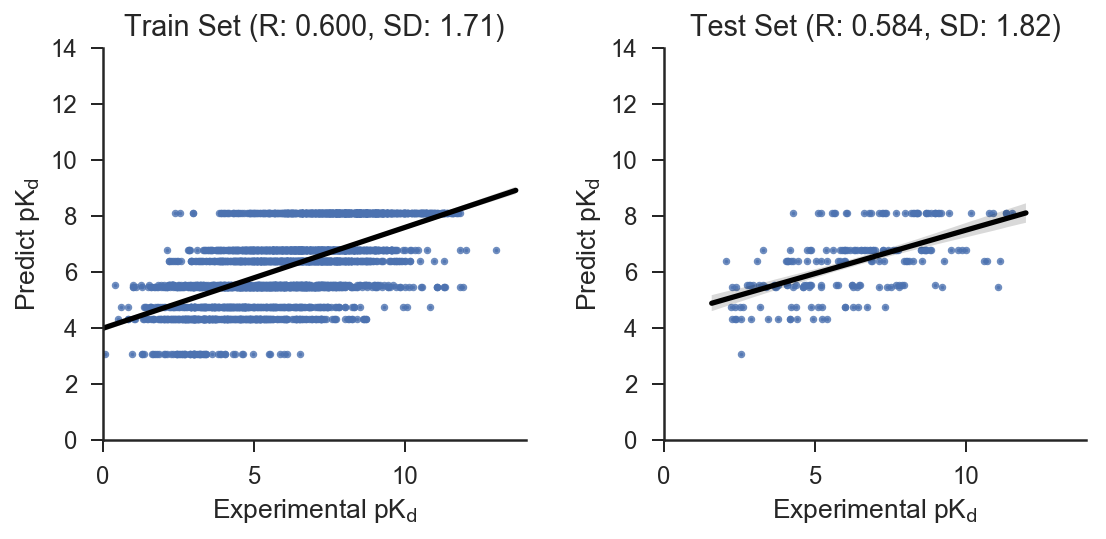

In [22]:
plotpKd(trainPredYtr.reshape(-1,1), trainY, testPredYtr.reshape(-1,1), testY)

# Random Forest

In [26]:
# model with 500 trees and mtry = 2, the min_sample to split is 5
rf = RandomForestRegressor( n_estimators = 500, max_features = 2, min_samples_split =5, oob_score = True)
# fit the model
rf.fit(trainX, trainY['pkd'].values)
# predict training set
trainPredYrf = rf.predict(trainX)
# predict test set
testPredYrf = rf.predict(testX)
# get oob prediction
oobPredYrf = rf.oob_prediction_
# get rsd
rsd1 = getRSD(trainPredYrf.reshape(-1,1), trainY, testPredYrf.reshape(-1,1), testY)
rsd2 = getRSD(oobPredYrf.reshape(-1,1), trainY, testPredYrf.reshape(-1,1), testY)

Train R: 0.955, SD: 0.64; Test  R: 0.681, SD: 1.64
Train R: 0.690, SD: 1.55; Test  R: 0.681, SD: 1.64


In [28]:
def plotpKdoob(trainPredY, trainY, testPredY, testY, oobPredY, oobY):
    sns.set_context("notebook", font_scale=1.2)
    sns.set_style("ticks")

    rsd1 = getRSD(trainPredYrf.reshape(-1,1), trainY, testPredYrf.reshape(-1,1), testY)
    rsd2 = getRSD(oobPredYrf.reshape(-1,1), trainY, testPredYrf.reshape(-1,1), testY)
    
    plt.figure(figsize = (12,4))

    plt.subplot(131)
    sns.regplot(x = trainY, y = trainPredYrf, color = 'k', scatter_kws = {'s':3, 'lw':2, 'color':color[0]})
    plt.xlabel(r'Experimental pK$_{\mathrm{d}}$')
    plt.ylabel(r'Predict pK$_{\mathrm{d}}$')
    plt.xlim(0,14)
    plt.ylim(0,14)
    plt.title('Train Set (R: %.3f, SD: %.2f)' %(rsd1[0],rsd1[1]))

    plt.subplot(132)
    sns.regplot(x = trainY, y = oobPredYrf,color = 'k', scatter_kws = {'s':3, 'lw':2, 'color':color[0]})
    plt.xlabel(r'Experimental pK$_{\mathrm{d}}$')
    plt.ylabel(r'OOB Predict pK$_{\mathrm{d}}$')
    plt.xlim(0,14)
    plt.ylim(0,14)
    plt.title('OOB Set (R: %.3f, SD: %.2f)' %(rsd2[0],rsd2[1]))

    plt.subplot(133)
    sns.regplot(x = testY, y = testPredYrf,color = 'k', scatter_kws = {'s':3, 'lw':2, 'color':color[0]})
    plt.xlabel(r'Experimental pK$_{\mathrm{d}}$')
    plt.ylabel(r'Predict pK$_{\mathrm{d}}$')
    plt.xlim(0,14)
    plt.ylim(0,14)
    plt.title('Test Set (R: %.3f, SD: %.2f)' %(rsd1[2],rsd1[3]))

    sns.despine()
    plt.tight_layout()
    #plt.savefig('images/RF_OOB.pdf')
    plt.show()

Train R: 0.955, SD: 0.64; Test  R: 0.681, SD: 1.64
Train R: 0.690, SD: 1.55; Test  R: 0.681, SD: 1.64


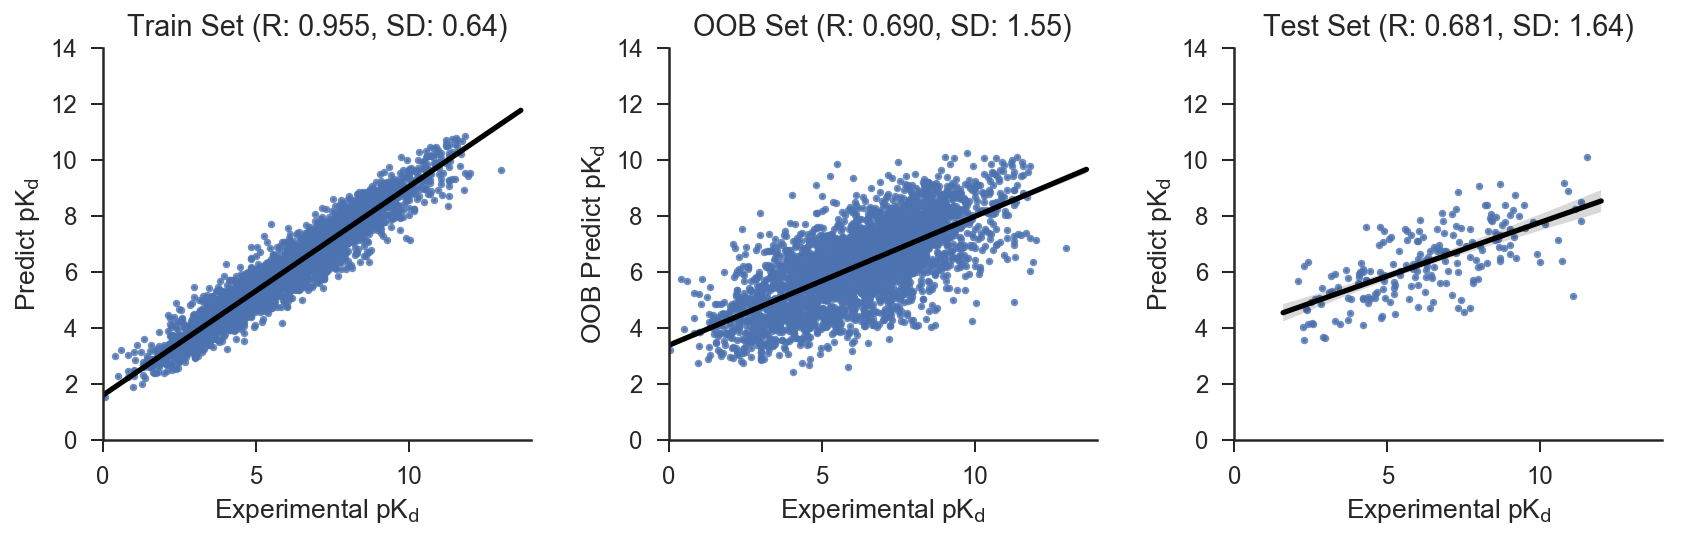

In [29]:
plotpKdoob(trainPredYrf.reshape(-1,1), trainY, testPredYrf.reshape(-1,1), testY,oobPredYrf.reshape(-1,1), trainY )

# Feature Importance (Gini)

In [30]:
imps = rf.feature_importances_
indices = np.argsort(imps)[::-1]
for nm, imp in zip(trainX.columns[indices], imps[indices]):
    print("%16s : %2d %%" %(nm, int(imp*100)))

          gauss2 : 25 %
     hydrophobic : 22 %
          gauss1 : 18 %
           hbond : 11 %
       repulsion : 10 %
            nrot : 10 %


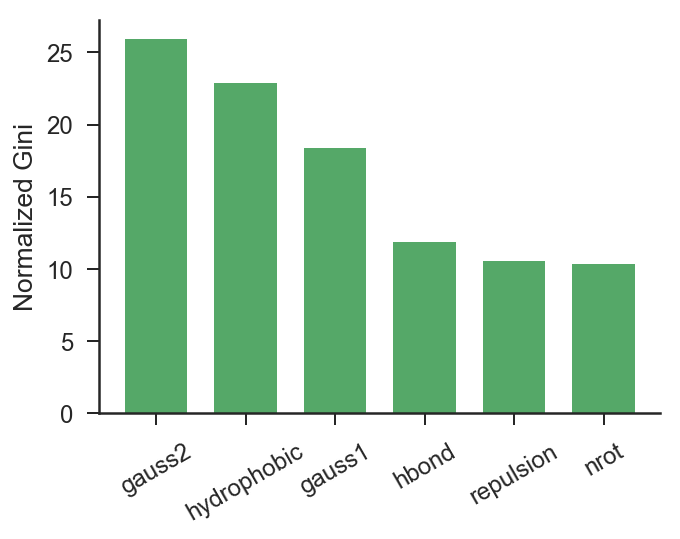

In [31]:
fig, ax = plt.subplots(figsize = (5,4))
rects1 = ax.bar(range(6), imps[indices]*100, width = 0.7, align='center', color = color[1])
plt.xticks(range(6), trainX.columns[indices],  rotation = 30)
plt.ylabel('Normalized Gini')
sns.despine()
plt.tight_layout()
# plt.savefig('images/RF_importance.pdf')
plt.show()

# Parameters: number of trees and mtry

In [32]:
rfrsd = []
ntree = [20,40,60,80,100,150,200,250,300,400,500,600,700,800]
for i in ntree:
    rf = RandomForestRegressor( n_estimators = i, max_features = 2, min_samples_split =5, oob_score = True)
    rf.fit(trainX, trainY['pkd'].values)
    trainPredYrf = rf.predict(trainX)
    testPredYrf = rf.predict(testX)
    oobPredYrf = rf.oob_prediction_
    print('ntree:',i)
    rsd1 = getRSD(trainPredYrf.reshape(-1,1), trainY, testPredYrf.reshape(-1,1), testY)
    rsd2 = getRSD(oobPredYrf.reshape(-1,1), trainY, testPredYrf.reshape(-1,1), testY)
    rfrsd.append([rsd1[0], rsd1[1], rsd2[0], rsd2[1], rsd1[2], rsd1[3] ])

/Users/yingkai/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:723: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


ntree: 20
Train R: 0.943, SD: 0.71; Test  R: 0.653, SD: 1.70
Train R: 0.635, SD: 1.65; Test  R: 0.653, SD: 1.70
ntree: 40
Train R: 0.949, SD: 0.68; Test  R: 0.681, SD: 1.64
Train R: 0.664, SD: 1.60; Test  R: 0.681, SD: 1.64
ntree: 60
Train R: 0.951, SD: 0.66; Test  R: 0.686, SD: 1.63
Train R: 0.678, SD: 1.57; Test  R: 0.686, SD: 1.63
ntree: 80
Train R: 0.952, SD: 0.65; Test  R: 0.688, SD: 1.63
Train R: 0.680, SD: 1.57; Test  R: 0.688, SD: 1.63
ntree: 100
Train R: 0.953, SD: 0.65; Test  R: 0.685, SD: 1.63
Train R: 0.685, SD: 1.56; Test  R: 0.685, SD: 1.63
ntree: 150
Train R: 0.953, SD: 0.65; Test  R: 0.672, SD: 1.66
Train R: 0.686, SD: 1.56; Test  R: 0.672, SD: 1.66
ntree: 200
Train R: 0.954, SD: 0.64; Test  R: 0.682, SD: 1.64
Train R: 0.690, SD: 1.55; Test  R: 0.682, SD: 1.64
ntree: 250
Train R: 0.954, SD: 0.64; Test  R: 0.683, SD: 1.64
Train R: 0.690, SD: 1.55; Test  R: 0.683, SD: 1.64
ntree: 300
Train R: 0.954, SD: 0.64; Test  R: 0.684, SD: 1.64
Train R: 0.690, SD: 1.55; Test  R: 0.6

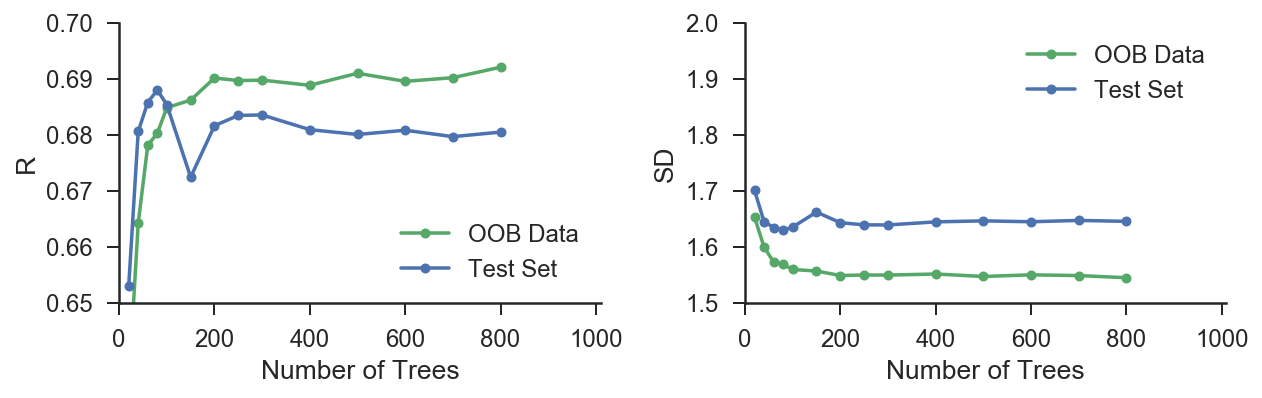

In [33]:
rfrsd = np.array(rfrsd)
plt.figure(figsize = (9,3))

plt.subplot(121)
#plt.plot(ntree, rfrsd[:,0], 'o-', color = color[2], ms = 5, label = 'Training Set')
plt.plot(ntree, rfrsd[:,2], 'o-',color = color[1], ms = 5, label = 'OOB Data')
plt.plot(ntree, rfrsd[:,4], 'o-',color = color[0], ms = 5, label = 'Test Set')
plt.ylabel('R')
plt.xlabel('Number of Trees')
plt.ylim(0.65,0.7)
plt.xlim(0,1010)
plt.legend(loc = 'best')

plt.subplot(122)
#plt.plot(ntree, rfrsd[:,1], 'ro-', color = color[2], ms = 5, label = 'Training Set')
plt.plot(ntree, rfrsd[:,3], 'o-',color = color[1], ms = 5, label = 'OOB Data')
plt.plot(ntree, rfrsd[:,5], 'o-',color = color[0], ms = 5, label = 'Test Set')
plt.ylabel('SD')
plt.xlabel('Number of Trees')
plt.ylim(1.5,2)
plt.xlim(0,1010)
plt.legend(loc = 1)

sns.despine()
plt.tight_layout()
#plt.savefig('images/RF_NTrees.pdf')
plt.show()

In [35]:
rfrsd = []
mtry = [1,2,3,4,5,6]
for i in mtry:
    rf = RandomForestRegressor( n_estimators = 500, max_features = i, min_samples_split =5, oob_score = True)
    rf.fit(trainX, trainY['pkd'].values)
    trainPredYrf = rf.predict(trainX)
    testPredYrf = rf.predict(testX)
    oobPredYrf = rf.oob_prediction_
    print('mtry:',i)
    rsd1 = getRSD(trainPredYrf.reshape(-1,1), trainY, testPredYrf.reshape(-1,1), testY)
    rsd2 = getRSD(oobPredYrf.reshape(-1,1), trainY, testPredYrf.reshape(-1,1), testY)
    rfrsd.append([rsd1[0], rsd1[1], rsd2[0], rsd2[1], rsd1[2], rsd1[3] ])

mtry: 1
Train R: 0.946, SD: 0.69; Test  R: 0.690, SD: 1.63
Train R: 0.689, SD: 1.55; Test  R: 0.690, SD: 1.63
mtry: 2
Train R: 0.954, SD: 0.64; Test  R: 0.682, SD: 1.64
Train R: 0.690, SD: 1.55; Test  R: 0.682, SD: 1.64
mtry: 3
Train R: 0.957, SD: 0.62; Test  R: 0.670, SD: 1.67
Train R: 0.689, SD: 1.55; Test  R: 0.670, SD: 1.67
mtry: 4
Train R: 0.959, SD: 0.61; Test  R: 0.667, SD: 1.67
Train R: 0.688, SD: 1.55; Test  R: 0.667, SD: 1.67
mtry: 5
Train R: 0.960, SD: 0.60; Test  R: 0.662, SD: 1.68
Train R: 0.689, SD: 1.55; Test  R: 0.662, SD: 1.68
mtry: 6
Train R: 0.960, SD: 0.60; Test  R: 0.659, SD: 1.69
Train R: 0.688, SD: 1.55; Test  R: 0.659, SD: 1.69


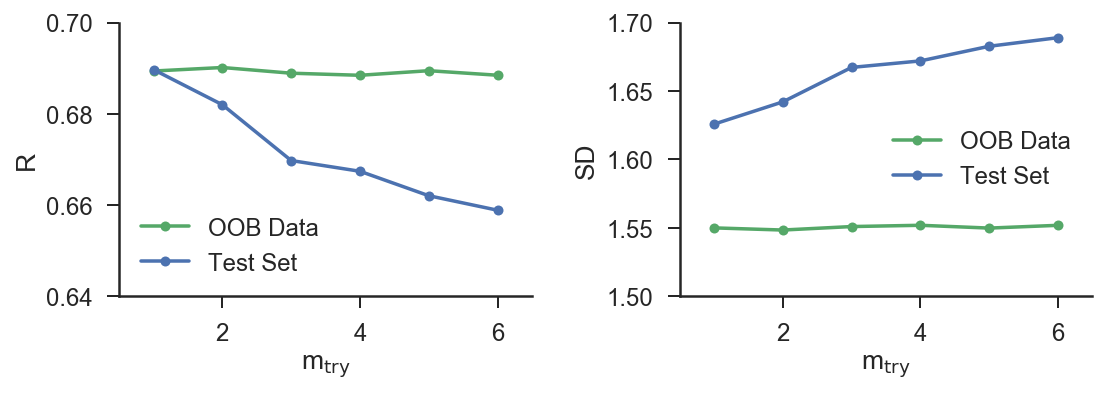

In [38]:
rfrsd = np.array(rfrsd)

plt.figure(figsize = (8,3))

plt.subplot(121)
#plt.plot(ntree, rfrsd[:,0], 'o-',color = color[2], ms = 5, label = 'Training Set')
plt.plot(mtry, rfrsd[:,2], 'o-',color = color[1], ms = 5, label = 'OOB Data')
plt.plot(mtry, rfrsd[:,4], 'o-',color = color[0], ms = 5, label = 'Test Set')
plt.ylabel('R')
plt.xlabel('m$_{\mathrm{try}}$')
plt.ylim(0.64,0.7)
plt.xlim(0.5,6.5)
plt.legend(loc = 'best')

plt.subplot(122)

#plt.plot(ntree, rfrsd[:,1], 'o-',color = color[2], ms = 5, label = 'Training Set')
plt.plot(mtry, rfrsd[:,3], 'o-',color = color[1], ms = 5, label = 'OOB Data')
plt.plot(mtry, rfrsd[:,5], 'o-',color = color[0], ms = 5, label = 'Test Set')
plt.ylabel('SD')
plt.xlabel('m$_{\mathrm{try}}$')
plt.ylim(1.5,1.7)
plt.xlim(0.5,6.5)
plt.xticks()
plt.legend(loc = 'best')

sns.despine()
plt.tight_layout()
#plt.savefig('images/RF_mtry.pdf')

plt.show()